In [1]:
pip install tensorflow


  Using cached tensorflow-2.15.0-cp310-cp310-win_amd64.whl (2.1 kB)
  Using cached tensorflow_intel-2.15.0-cp310-cp310-win_amd64.whl (300.9 MB)


You should consider upgrading via the 'c:\Users\hittb\AppData\Local\Programs\Python\Python310\python.exe -m pip install --upgrade pip' command.


In [2]:
pip install matplotlib


[notice] A new release of pip available: 22.2.1 -> 23.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [1]:
pip install tensorflow.keras

Note: you may need to restart the kernel to use updated packages.


ERROR: Could not find a version that satisfies the requirement tensorflow.keras (from versions: none)
ERROR: No matching distribution found for tensorflow.keras


In [ ]:
pip install IPython

In [4]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
# from IPython.display import HTML


In [5]:
BATCH_SIZE = 32
IMAGE_SIZE = 256
CHANNELS = 3
EPOCHS = 70

In [6]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "leaf_dataset",
    seed=123,
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 5904 files belonging to 50 classes.


In [7]:
class_names = dataset.class_names
class_names

['Alpinia Galanga (Rasna)',
 'Amaranthus Viridis (Arive-Dantu)',
 'Artocarpus Heterophyllus (Jackfruit)',
 'Azadirachta Indica (Neem)',
 'Basella Alba (Basale)',
 'Brassica Juncea (Indian Mustard)',
 'Carissa Carandas (Karanda)',
 'Citrus Limon (Lemon)',
 'Ficus Auriculata (Roxburgh fig)',
 'Ficus Religiosa (Peepal Tree)',
 'Hibiscus Rosa-sinensis',
 'Jasminum (Jasmine)',
 'Mangifera Indica (Mango)',
 'Mentha (Mint)',
 'Moringa Oleifera (Drumstick)',
 'Muntingia Calabura (Jamaica Cherry-Gasagase)',
 'Murraya Koenigii (Curry)',
 'Nerium Oleander (Oleander)',
 'Nyctanthes Arbor-tristis (Parijata)',
 'Ocimum Tenuiflorum (Tulsi)',
 'Piper Betle (Betel)',
 'Plectranthus Amboinicus (Mexican Mint)',
 'Pongamia Pinnata (Indian Beech)',
 'Psidium Guajava (Guava)',
 'Punica Granatum (Pomegranate)',
 'Santalum Album (Sandalwood)',
 'Syzygium Cumini (Jamun)',
 'Syzygium Jambos (Rose Apple)',
 'Tabernaemontana Divaricata (Crape Jasmine)',
 'Trigonella Foenum-graecum (Fenugreek)',
 'arjun_diseased',

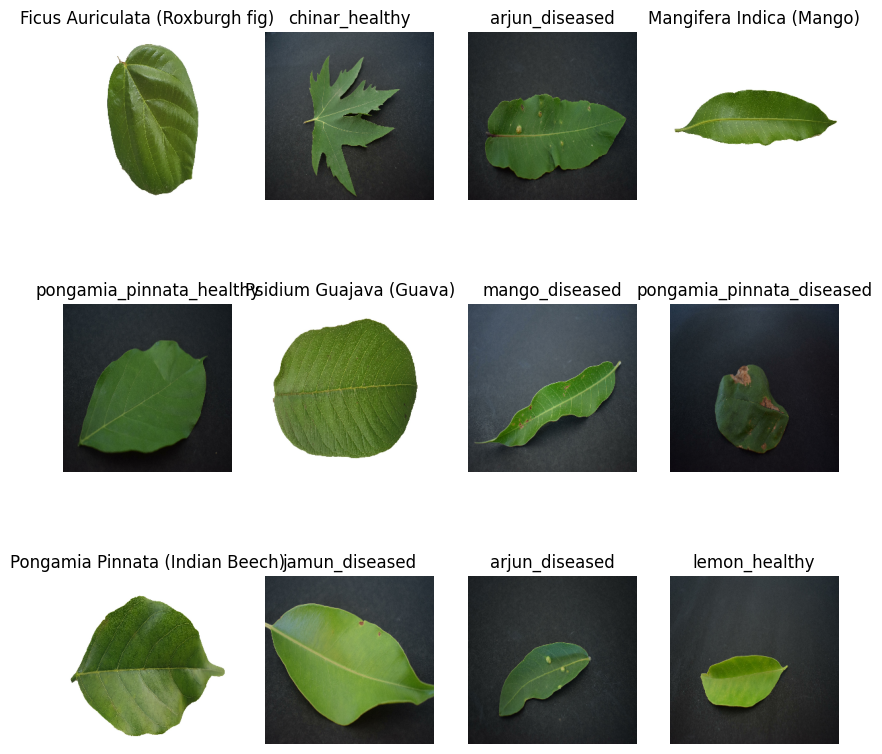

In [9]:
plt.figure(figsize=(10, 10))
for image_batch, labels_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")

In [10]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [11]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [12]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [13]:
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  layers.experimental.preprocessing.Rescaling(1./255),
])

In [14]:
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
])

In [15]:
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

In [16]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 50

model = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)
model.summary()


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2  (32, 127, 127, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (32, 62, 62, 64)          0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (32, 60, 60, 64)        

In [17]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [18]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=70,
)

Epoch 1/70


148/148 [==============================] - 333s 2s/step - loss: 3.3961 - accuracy: 0.0799 - val_loss: 2.7692 - val_accuracy: 0.1840
Epoch 2/70
148/148 [==============================] - 185s 1s/step - loss: 2.6553 - accuracy: 0.1862 - val_loss: 2.4913 - val_accuracy: 0.2413
Epoch 3/70
148/148 [==============================] - 168s 1s/step - loss: 2.3344 - accuracy: 0.2547 - val_loss: 2.0840 - val_accuracy: 0.3351
Epoch 4/70
148/148 [==============================] - 177s 1s/step - loss: 1.9825 - accuracy: 0.3405 - val_loss: 2.0600 - val_accuracy: 0.3229
Epoch 5/70
148/148 [==============================] - 174s 1s/step - loss: 1.7618 - accuracy: 0.4038 - val_loss: 1.9441 - val_accuracy: 0.3576
Epoch 6/70
148/148 [==============================] - 171s 1s/step - loss: 1.6033 - accuracy: 0.4638 - val_loss: 1.6728 - val_accuracy: 0.4635
Epoch 7/70
148/148 [==============================] - 163s 1s/step - loss: 1.4313 - accuracy: 0.5102 - val_loss: 1.4171 - val_accuracy: 0.53

In [19]:
scores = model.evaluate(test_ds)

19/19 [==============================] - 97s 396ms/step - loss: 0.2375 - accuracy: 0.9309


first image to predict
actual label: Amaranthus Viridis (Arive-Dantu)
1/1 [==============================] - 1s 977ms/step
predicted label: Amaranthus Viridis (Arive-Dantu)


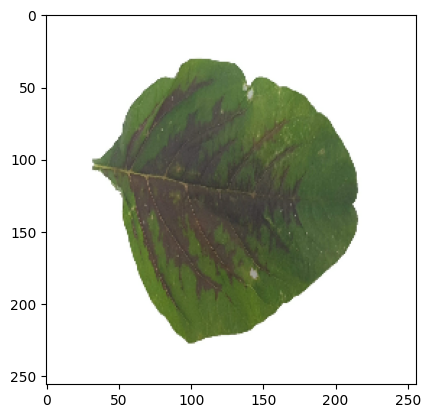

In [20]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):
    
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])
    
    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

In [42]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 [==============================] - 0s 23ms/step


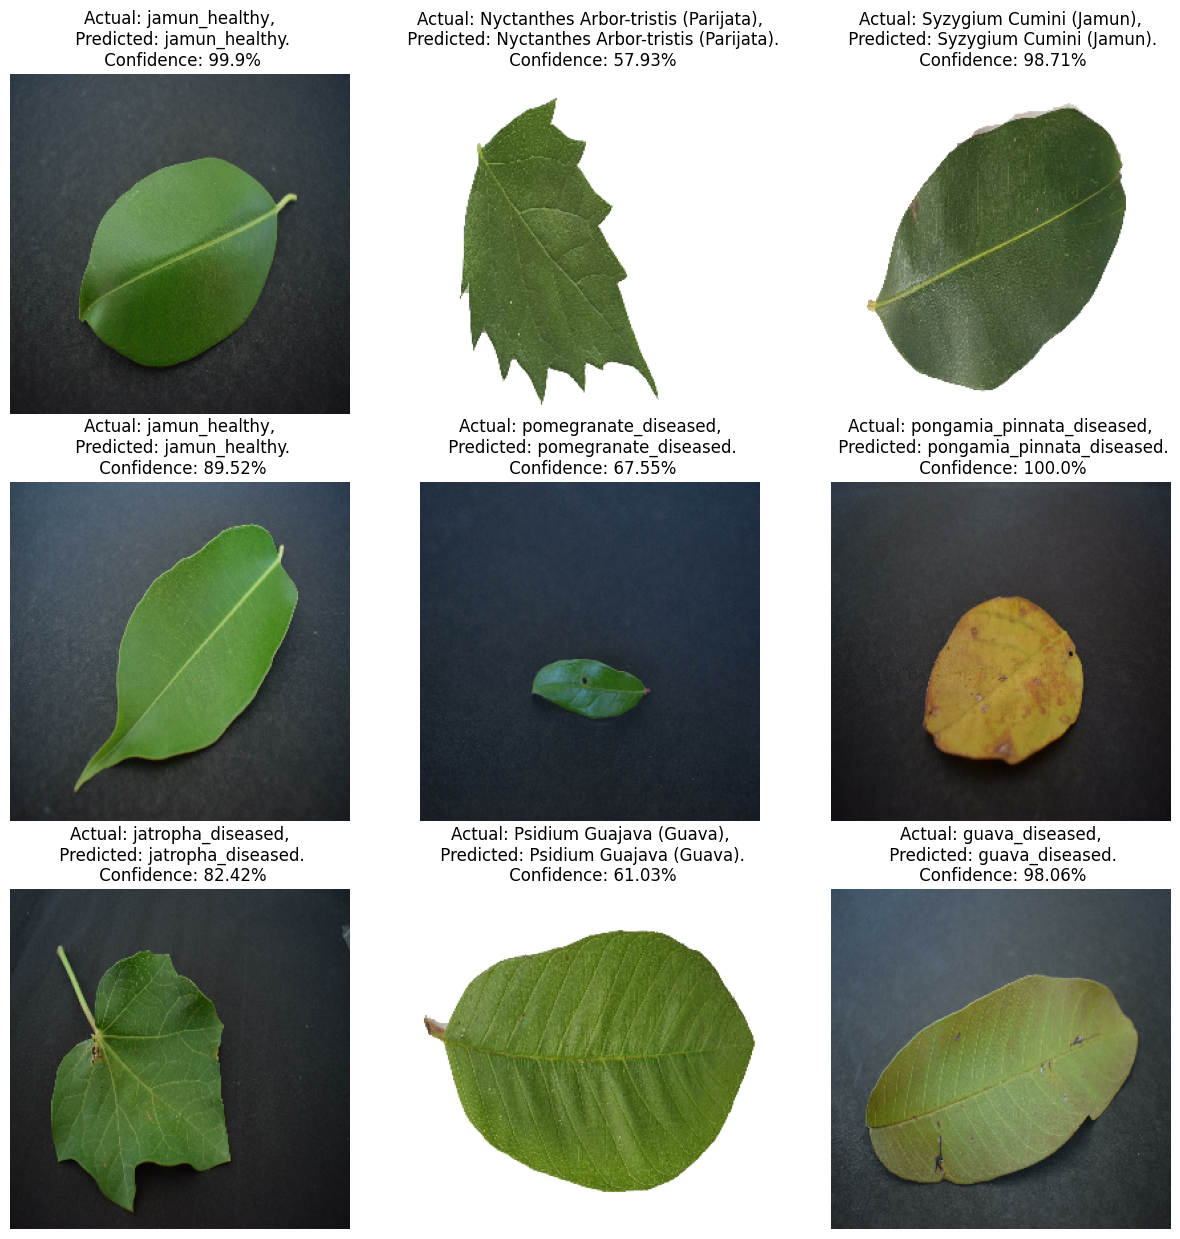

In [43]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")

In [27]:
import os
model_version=max([int(i) for i in os.listdir("./models") + [0]])+1
model.save(f"./models/{model_version}")

INFO:tensorflow:Assets written to: ./models/1\assets


INFO:tensorflow:Assets written to: ./models/1\assets


In [28]:
model.save("./leaf_identification.h5")

c:\Users\hittb\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
